# Anomaly Detection in High Dimensions Using Auto-encoder
Anomaly detection detects data points (outliers) which do not conform to an expected pattern or other items in a dataset. In this notebook we demonstrate how to do unsupervised anomaly detection in high dimensions using auto-encoder.

We are using one of the HiCS synthetic data sets ([link](https://www.ipd.kit.edu/~muellere/HiCS)) for demo. The data set contains 100 dimensions and 1000 instances, with 136 of them being outliers. Alternative datasets are in "data" directory, however, typically datasets with higher dimension and lower outlier proportion will have a better performance. Some results are shown in "figure" directory. Data points with higher reconstruction error are more likely to be outliers, and this notebook can also show which dimensions the points are outlying.

References:
* [Neural-based Outlier Discovery](https://edouardfouche.com/Neural-based-Outlier-Discovery)

## Initialization
* import necesary libraries and load data

In [1]:
from scipy.io import arff
import pandas as pd

from zoo.pipeline.api.keras.layers import Input, Dense
from zoo.pipeline.api.keras.models import Model

#dataset = "pendigits16"           #real world dataset
dataset = "synth_multidim_100_000"

data_dir = "data/"+dataset+".arff"

epoch = 2500

rawdata, _ = arff.loadarff(data_dir)
data = pd.DataFrame(rawdata)

## Data preprocessing
*  save the label and delete them from the original data set

In [2]:
labels = data['class'].astype(int)
del data['class']

labels[labels != 0] = 1

* MinMaxScaler is used since we need to keep the features of outliers

In [3]:
from sklearn.preprocessing import MinMaxScaler
data_norm = MinMaxScaler().fit_transform(data).astype('float32')

In [4]:
print "Instances: %d \nOutliers: %d\nAttributes: %d" % (len(data), sum(labels), len(data_norm[0]))

Instances: 1000 
Outliers: 136
Attributes: 100


## Build the model

In [5]:
compress_rate=0.8
origin_dim=len(data_norm[0])

input = Input(shape=(origin_dim,))
encode = Dense(int(compress_rate*origin_dim), activation='relu')(input)
decode = Dense(origin_dim, activation='sigmoid')(encode)

autoencoder = Model(input, decode)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdadelta
creating: createBCECriterion


## Training

In [6]:
autoencoder.fit(data_norm, data_norm,
                nb_epoch=epoch,
                batch_size=100)

## Prediction
* data are encoded and reconstructed

In [7]:
data_trans = autoencoder.predict(data_norm).collect()

## Evaluation
* calculate the euclidean distance from each point to its reconstruction

In [8]:
import numpy as np
dist = []
for i, x in enumerate(data_norm):
    dist.append(np.linalg.norm(data_norm[i] - data_trans[i]))
dist=np.array(dist)

* plot the ROC curve to assess the quality of detection

AUC = 0.892591


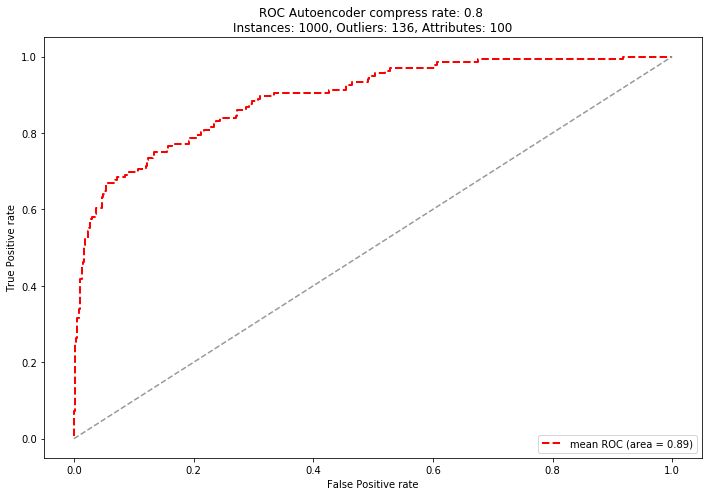

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)
print 'AUC = %f' % roc_auc

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, 'k--',
         label='mean ROC (area = %0.2f)' % roc_auc, lw=2, color='red')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder compress rate: %0.1f ' % compress_rate + "\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("./fig/"+dataset+".ROC.png")

plt.show()

* plot the outlier scores of each single data point

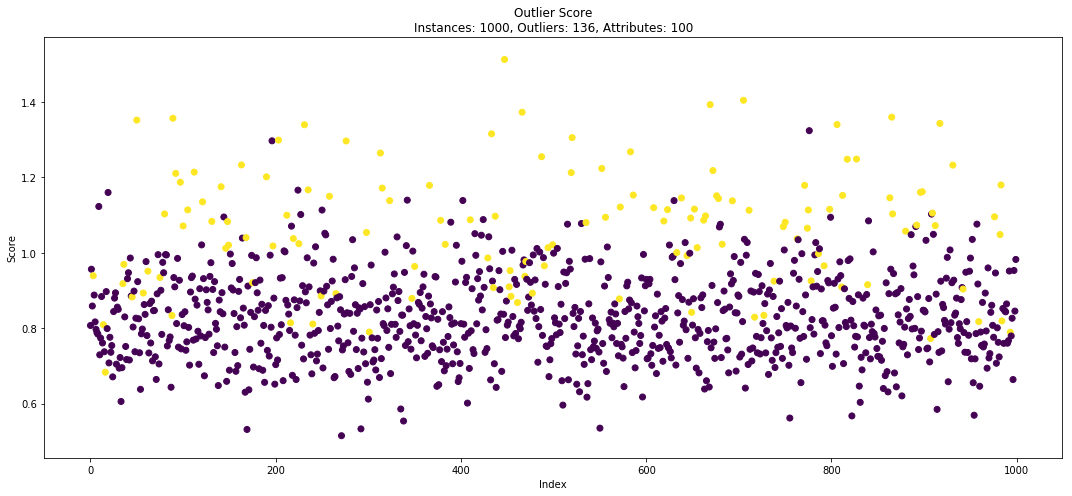

In [10]:
plt.figure(figsize=(15, 7))
plt.scatter(data.index, dist, c=labels)
plt.xlabel('Index')
plt.ylabel('Score')
plt.title("Outlier Score\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.tight_layout()
plt.savefig("./fig/"+dataset+".score.png")
plt.show()

* show top 20 data points with highest outlier score in descending order

In [11]:
print np.argsort(-dist)[0:20]

[447 705 669 466 865  89  50 917 806 231 776 433 520 203 196 276 583 313
 487 827]


* plot the reconstruction error in dimension of one point (here take point 3 as an example)

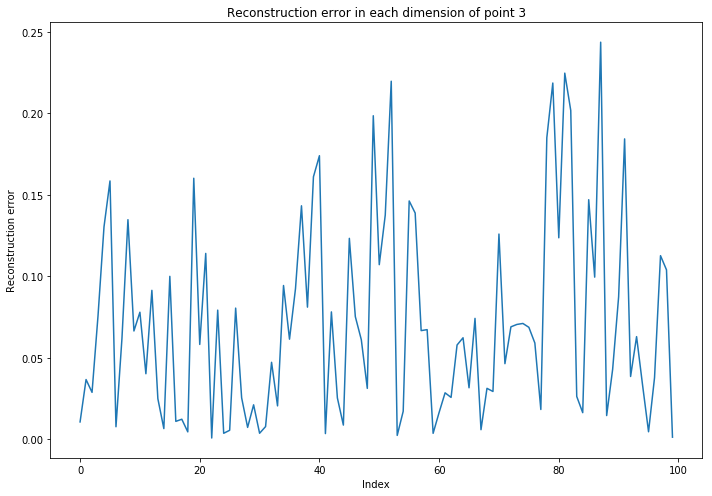

In [12]:
def error_in_dim(index):
    error = []
    for i, x in enumerate(data_norm[index]):
        error.append(abs(data_norm[index][i] - data_trans[index][i]))
    error=np.array(error)
    return error

example = 3

plt.figure(figsize=(10,7))
plt.plot(error_in_dim(example))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point %d" % example)
plt.tight_layout()
plt.show()

* show top 3 dimensions with highest reconstruction error in descending order

In [13]:
print np.argsort(-error_in_dim(example))[0:3]

[87 81 52]
